In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
import pathlib


import matplotlib as mpl
import matplotlib.pyplot as plt
import json, itertools

from sklearn.linear_model import Lasso # Lasso Regression for the glassbox model in LIME
from skimage.color import rgb2gray # Convert the unimportant areas into grayscale
from skimage.data import astronaut # example image
from skimage.segmentation import quickshift, mark_boundaries # image segmentation algorithm

import cv2

In [ ]:
from google.colab import drive
drive_dir = '/content/drive'
drive.mount(drive_dir, force_remount=True)

Mounted at /content/drive


In [ ]:
local_colab_dir = 'MyDrive/Colab Notebooks/'

dataset_path = f"{drive_dir}/{local_colab_dir}/Fresh Tea Leaves/data"
dataset_dir = pathlib.Path(dataset_path)

In [ ]:
train_batch = 128
val_batch = 128
img_height = 256
img_width = 256
IMG_SIZE = (img_height, img_width)
val_split = 0.2

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(dataset_dir,
                                                       validation_split=val_split,
                                                       subset="training",
                                                       seed=123,
                                                       image_size=(img_height, img_width),
                                                       batch_size=train_batch,
                                                       color_mode='rgb',  # Specify RGB color mode
                                                      )

image_test = []
label_test = []

# Append images and labels to the lists
for images, labels in train_ds:
    image_test.append(images.numpy())  # Convert tensor to numpy and store
    label_test.append(labels.numpy())

image_test = np.concatenate(image_test, axis=0)
label_test = np.concatenate(label_test, axis=0)

image_test = tf.image.convert_image_dtype(image_test, tf.float32)
image_test /= 255.0
image_test = image_test.numpy()


Found 885 files belonging to 8 classes.
Using 708 files for training.


In [ ]:
# Load data for Validation
val_ds = tf.keras.utils.image_dataset_from_directory(dataset_dir,
                                                     validation_split=val_split,
                                                     subset="validation",
                                                     seed=123,
                                                     image_size=(img_height, img_width),
                                                     batch_size=val_batch,
                                                     color_mode='rgb',  # Specify RGB color mode
                                                    #label_mode='categorical'  # Specify label mode
                                                    )

Found 885 files belonging to 8 classes.
Using 177 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

num_classes=len(class_names)
class_array = np.array(class_names)
class_dict = {}
for index, label in enumerate(class_array):
  class_dict[label] = index

label_test_str = [class_names[label] for label in label_test]


['Anthracnose', 'algal leaf', 'bird eye spot', 'brown blight', 'gray light', 'healthy', 'red leaf spot', 'white spot']


In [ ]:
model=keras.Sequential([

    layers.Conv2D(filters = 32,kernel_size = 3, strides = (2,2), padding='same', activation = 'relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size = (2,2)),

    layers.Conv2D(filters = 64,kernel_size = 3, strides = (2,2), padding='same', activation = 'relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(filters = 128, kernel_size = 3, padding='same', activation = 'relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),

    layers.Dense(64,),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Dropout(rate= 0.3),

    layers.Dense(128),
    layers.BatchNormalization() ,
    layers.ReLU(),
    layers.Dropout(rate= 0.23),

    layers.Dense(256),
    layers.BatchNormalization() ,
    layers.ReLU(),
    layers.Dropout(rate= 0.2),


    layers.Dense(8,activation='softmax')
])


model.compile(optimizer=keras.optimizers.Adam(learning_rate= 0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])


history = model.fit(train_ds,validation_data=val_ds, epochs=15)

Epoch 1/15
6/6 [==============================] - 64s 5s/step - loss: 2.0168 - accuracy: 0.2740 - val_loss: 10.9048 - val_accuracy: 0.1412
Epoch 2/15
6/6 [==============================] - 50s 5s/step - loss: 1.3821 - accuracy: 0.4477 - val_loss: 10.3773 - val_accuracy: 0.1412
Epoch 3/15
6/6 [==============================] - 52s 5s/step - loss: 1.1741 - accuracy: 0.5452 - val_loss: 5.8372 - val_accuracy: 0.1751
Epoch 4/15
6/6 [==============================] - 51s 5s/step - loss: 0.9417 - accuracy: 0.6314 - val_loss: 3.7016 - val_accuracy: 0.1695
Epoch 5/15
6/6 [==============================] - 52s 5s/step - loss: 0.7767 - accuracy: 0.6992 - val_loss: 2.9882 - val_accuracy: 0.1582
Epoch 6/15
6/6 [==============================] - 52s 5s/step - loss: 0.6638 - accuracy: 0.7528 - val_loss: 4.3191 - val_accuracy: 0.1469
Epoch 7/15
6/6 [==============================] - 60s 5s/step - loss: 0.4884 - accuracy: 0.8263 - val_loss: 3.3663 - val_accuracy: 0.1582
Epoch 8/15
6/6 [================

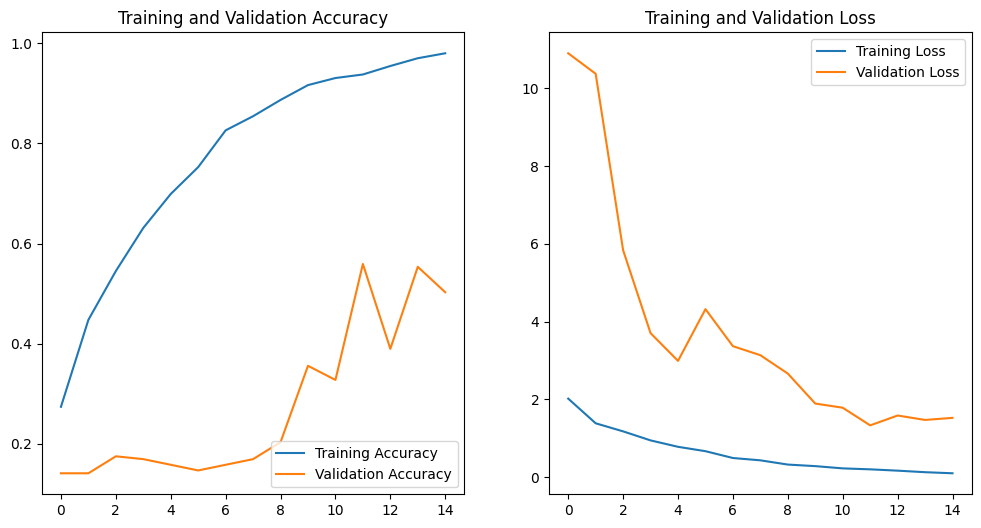

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


              precision    recall  f1-score   support

           0       0.26      0.35      0.30        17
           1       1.00      0.77      0.87        13
           2       0.25      0.83      0.38        12
           3       0.90      0.47      0.62        19
           4       0.78      0.32      0.45        22
           5       1.00      1.00      1.00        12
           6       0.54      1.00      0.70        13
           7       0.00      0.00      0.00        20

    accuracy                           0.52       128
   macro avg       0.59      0.59      0.54       128
weighted avg       0.58      0.52      0.50       128



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


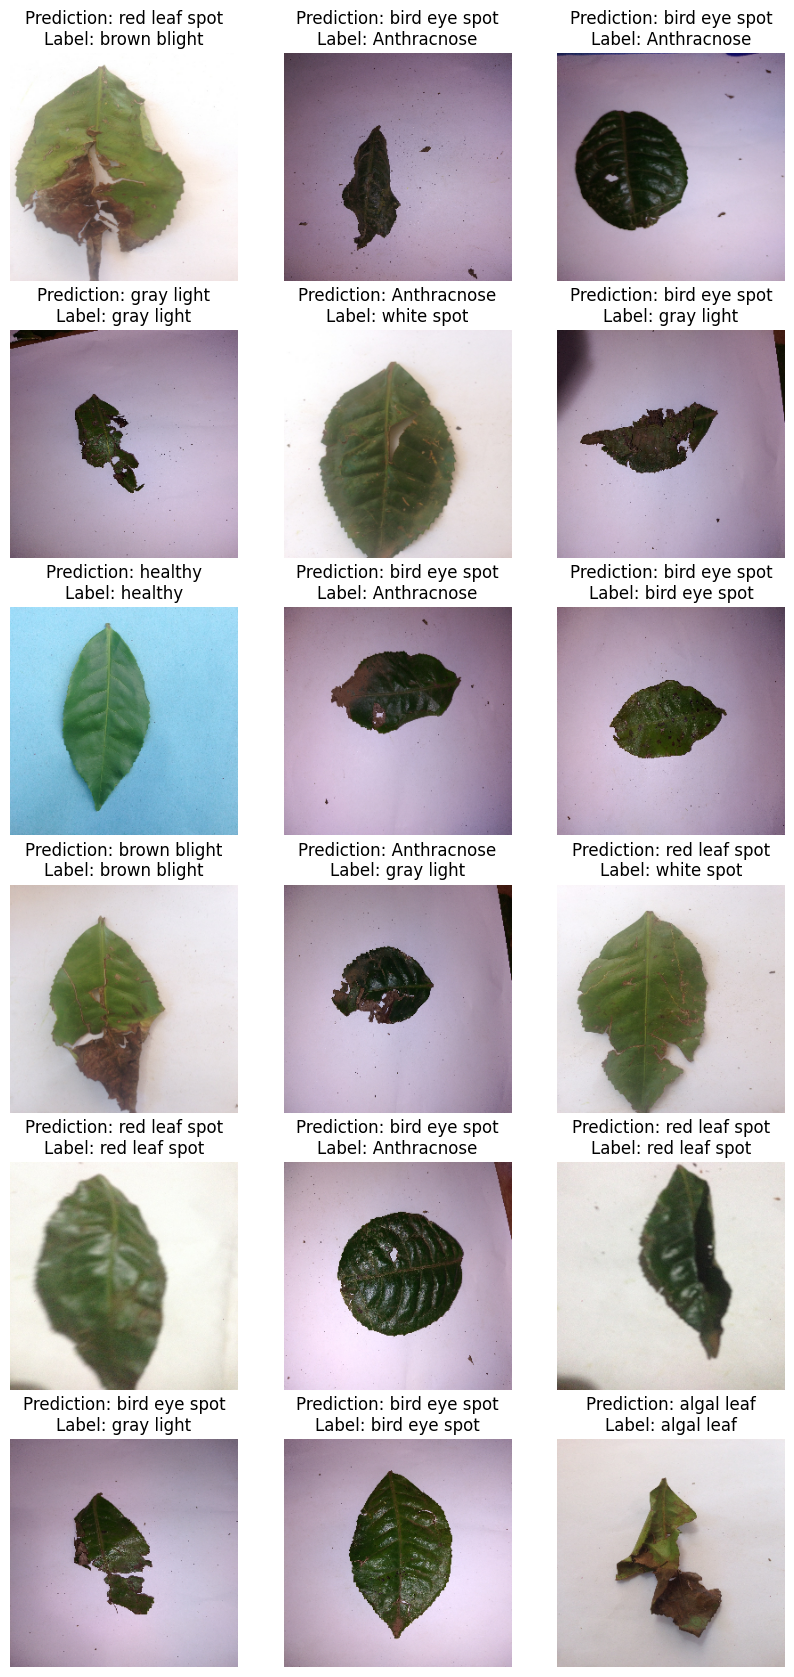

In [ ]:
image_batch, label_batch = val_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

class_predictions = []
for i in predictions:
    class_prediction = np.argmax(i)
    class_predictions.append(class_prediction)

print()
print(classification_report(label_batch, class_predictions))

plt.figure(figsize=(10, 21))
for i in range(18):
    ax = plt.subplot(6, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title("Prediction: "+class_names[class_predictions[i]]+"\nLabel: "+class_names[label_batch[i]])
    plt.axis("off")

In [ ]:
def safe_quickshift(original_image, **kwargs):
    return quickshift(np.float64(original_image), **kwargs)

def fudge_image(original_image, segmentation):
    """fudge each segments of the image"""
    fudged_image = original_image.copy()
    for each_seg in np.unique(segmentation):
        each_seg_area_mask = (segmentation == each_seg)
        fudged_image[each_seg_area_mask] = np.mean(
            fudged_image[each_seg_area_mask], axis=0)
    return fudged_image

# def perturb_image(original_image, fudged_image, segmentation,
#                   seed=None):
#     """return the perturbed image and the segmentation vector"""
#     rng = np.random.default_rng(seed=seed)

#     n_segments = len(np.unique(segmentation))
#     # randomly choose image segments to perturb
#     segmentation_vector_mask = rng.choice([True, False], size = n_segments)

#     perturbed_image = fudged_image.copy()
#     sampled_area_mask = segmentation_vector_mask[segmentation]
#     perturbed_image[sampled_area_mask] = original_image[sampled_area_mask]

#     return perturbed_image, segmentation_vector_mask.astype(np.int64)

def perturb_image(original_image, fudged_image, segmentation, seed=None):
    rng = np.random.default_rng(seed=seed)
    n_segments = len(np.unique(segmentation))
    segmentation_vector_mask = rng.choice([True, False], size=n_segments)

    perturbed_image = fudged_image.copy()
    sampled_area_mask = segmentation_vector_mask[segmentation]
    perturbed_image[sampled_area_mask] = original_image[sampled_area_mask]

    return perturbed_image, segmentation_vector_mask.astype(np.int64)


In [ ]:
seg_params = dict(kernel_size=4, max_dist=6, ratio=0.4)

index = 219
image = image_test[index]
label = label_test_str[index]
label_index = class_dict[label]

seg = safe_quickshift(image, **seg_params)
fudged = fudge_image(image, seg)

def image_weight_kernel(original_image, perturbed_image, kernel_size=5.0):
    # for a single RGB colored image only
    assert original_image.ndim == 3
    assert original_image.shape[2] == 3

    image_squared_distance = np.sum((original_image - perturbed_image)**2)
    lime_weights = np.exp(-image_squared_distance/(kernel_size**2))

    return lime_weights


def generate_lime_training_data(original_image, fudged_image, segmentation,
                                original_label_index, cnn_model,
                                n_samples=400, initial_seed=None):
    """Returns the training data for the glassbox model that LIME uses to
      interpret image models.
    lime_X: Collection of segmentation vectors as the independent variable
      for the glassbox model np.array in the shape (n_samples, n_segments)
    lime_y: The CNN model's predicted probabilities on the true label from
      the perturbed images np.array in the shape (n_samples,)
    lime_w: The weights on each perturbed image from the function
      `image_weight_kernel()`
    """
    lime_X, lime_y, lime_w = [], [], []
    rng = np.random.default_rng(seed=initial_seed)

    for i in range(n_samples):
        seed = rng.integers(2**63)

        perturbed_image, segmentation_vector = perturb_image(original_image, fudged_image, segmentation)
        distance_weight = image_weight_kernel(original_image, perturbed_image)
        cnn_output = tf.squeeze(cnn_model(perturbed_image[np.newaxis, :]))
        predicted_probability = cnn_output[original_label_index]

        lime_X += [segmentation_vector]
        lime_y += [predicted_probability]
        lime_w += [distance_weight]

    lime_X, lime_y, lime_w = np.array(lime_X), np.array(lime_y), np.array(lime_w)

    return lime_X, lime_y, lime_w

def rgb2gray_3ch(original_image):
      """Desaturate the original image by repeating the gray channel three times"""
      gray_image_1ch = rgb2gray(original_image)[:, :, np.newaxis]
      gray_image_3ch = np.repeat(gray_image_1ch, repeats=3, axis=2)
      return gray_image_3ch

def get_glassbox_image(original_image, fudged_image, segmentation, lime_X, lime_y, lime_w):
      """returns the glassbox image
      in which the important part is in the original color
      and the unimportant part is fudged and grayscaled"""

      glassbox_lasso = Lasso(alpha=0.001).fit(lime_X, lime_y, sample_weight=lime_w) # this is step 4 where we train the glassbox model
      important_seg_mask = (glassbox_lasso.coef_ > 0)
      important_area_mask = important_seg_mask[segmentation]

      glassbox_image = rgb2gray_3ch(fudged_image)
      glassbox_image[important_area_mask] = original_image[important_area_mask]

      return glassbox_image

def lime_image(original_image, original_label, label_dict, cnn_model,
               seg_params=seg_params, n_samples=400, initial_seed=None):
      """returns the glassbox image, fudged image, and segmentation"""
      original_label_index = label_dict[original_label]


      segmentation = safe_quickshift(original_image, **seg_params)
      fudged_image = fudge_image(original_image, segmentation)
      lime_X, lime_y, lime_w = generate_lime_training_data(original_image, fudged_image, segmentation, original_label_index, cnn_model)
      glassbox_image = get_glassbox_image(original_image, fudged_image, segmentation, lime_X, lime_y, lime_w)

      return glassbox_image, fudged_image, segmentation

def display_lime(original_image, fudged_image, segmentation,
                 glassbox_image,
                 mode=None):
          fig, ax = plt.subplots(1, 3, figsize=(12, 4))
          ax[0].imshow(original_image)
          ax[0].set_title("Orignal Image")
          ax[1].imshow(mark_boundaries(fudged_image, segmentation, mode=mode))
          ax[1].set_title("Segmented and fudged")
          ax[2].imshow(glassbox_image)
          ax[2].set_title("LIME")
          ax[0].set_axis_off()
          ax[1].set_axis_off()
          ax[2].set_axis_off()

          return [fig, ax]

1/1 [==============================] - 0s 218ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 39ms/step


CPU times: user 6min 37s, sys: 6.83 s, total: 6min 43s
Wall time: 6min 17s


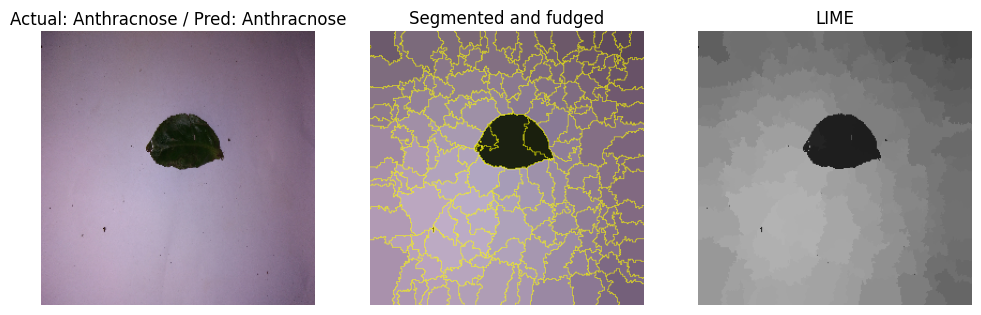

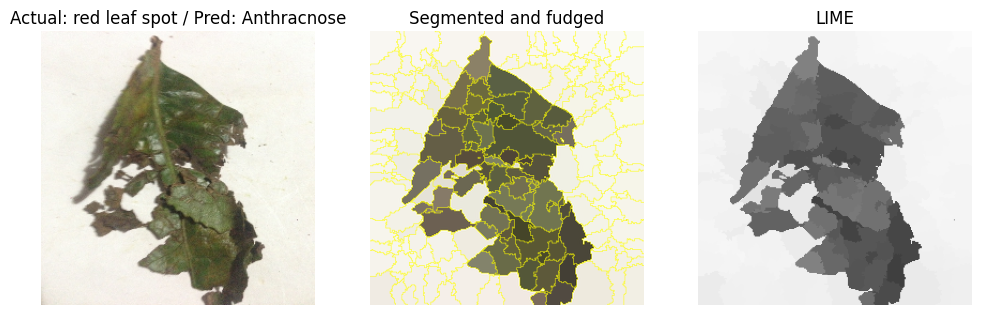

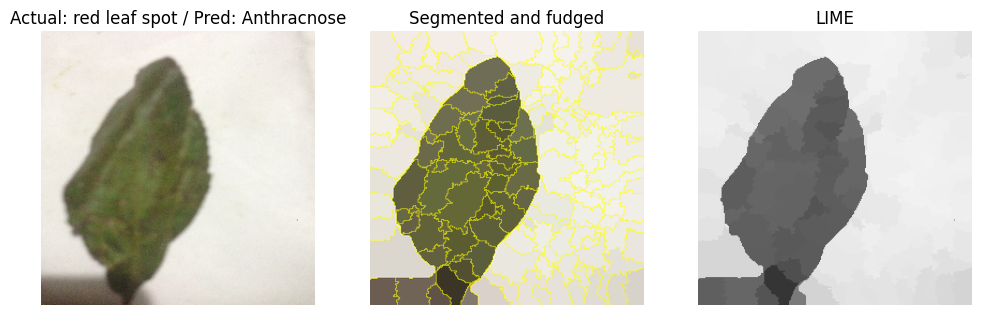

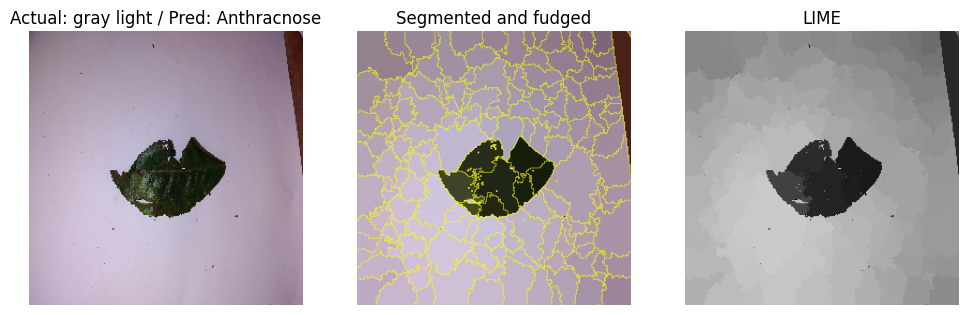

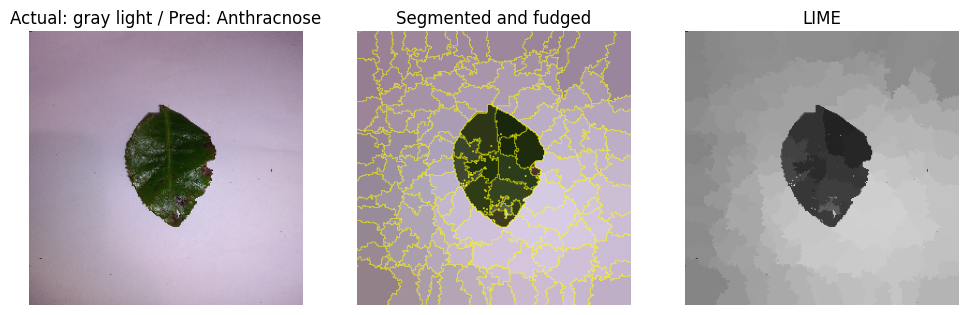

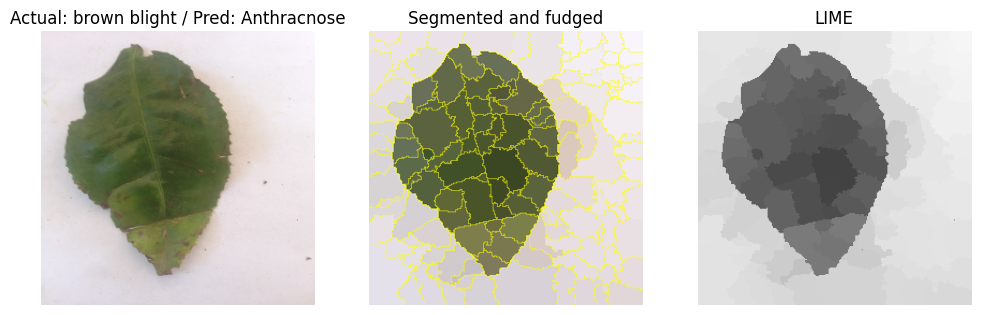

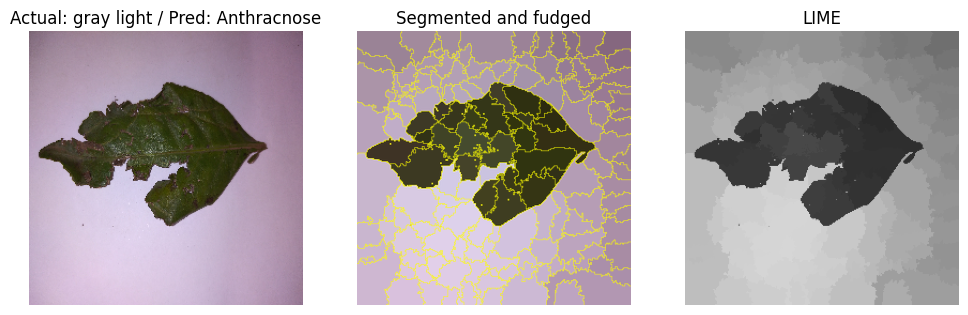

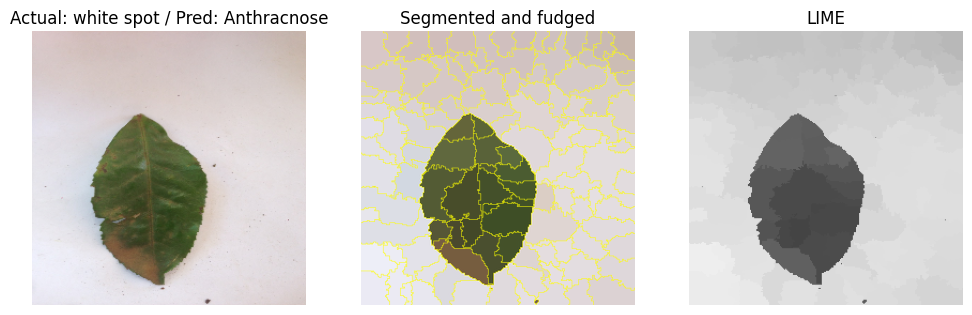

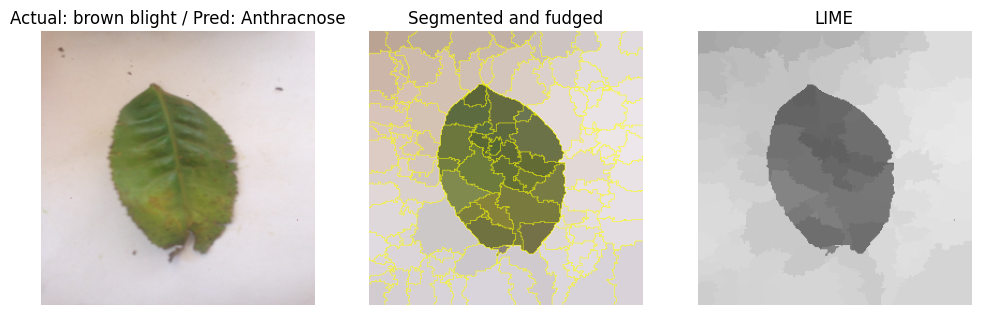

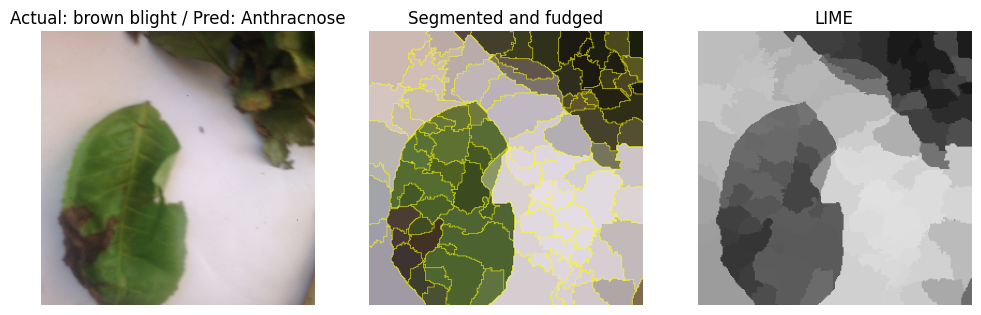

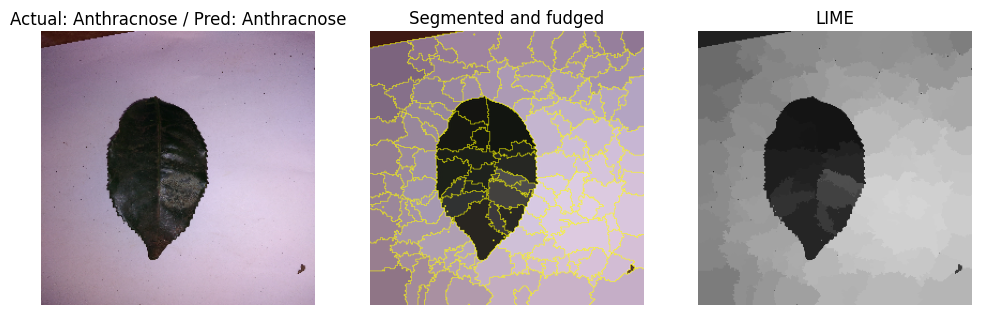

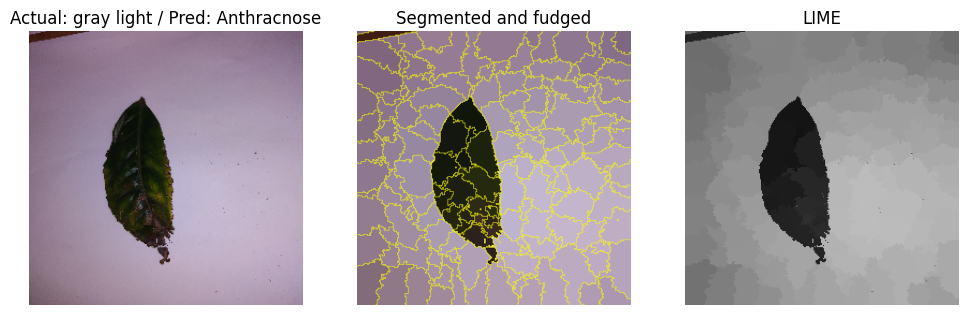

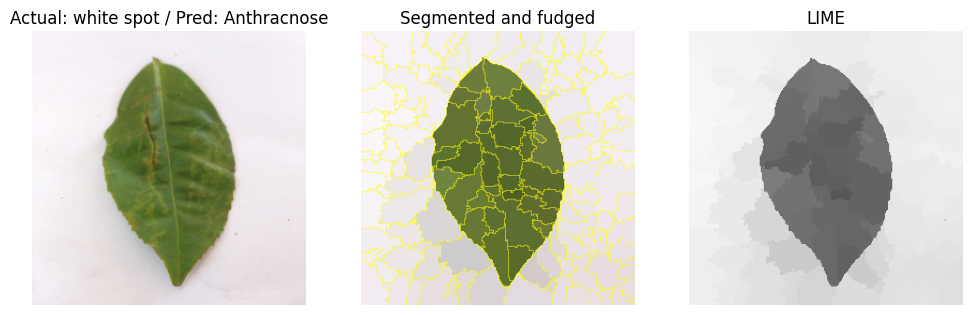

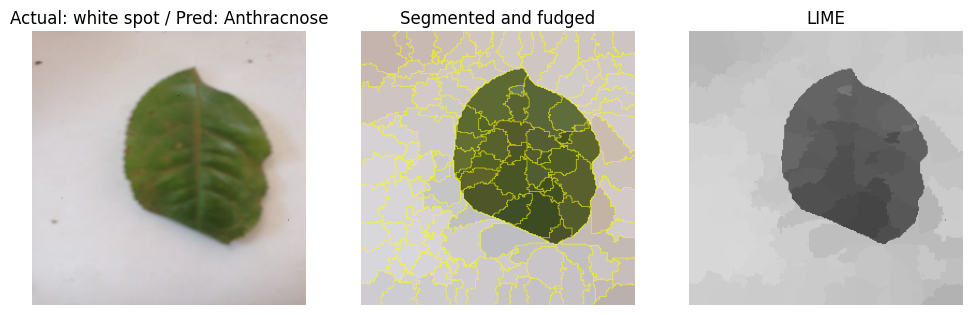

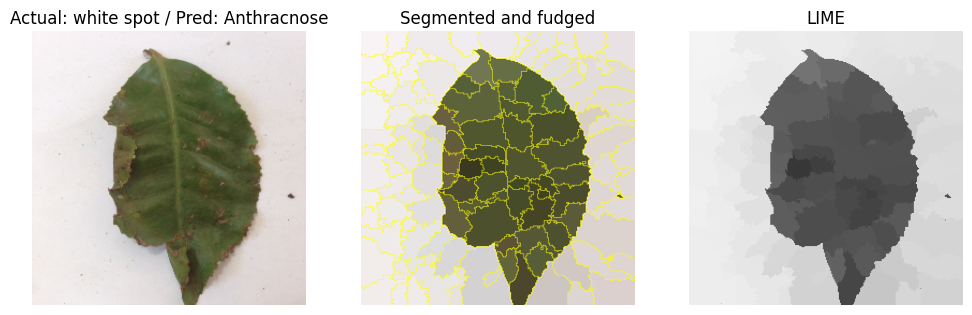

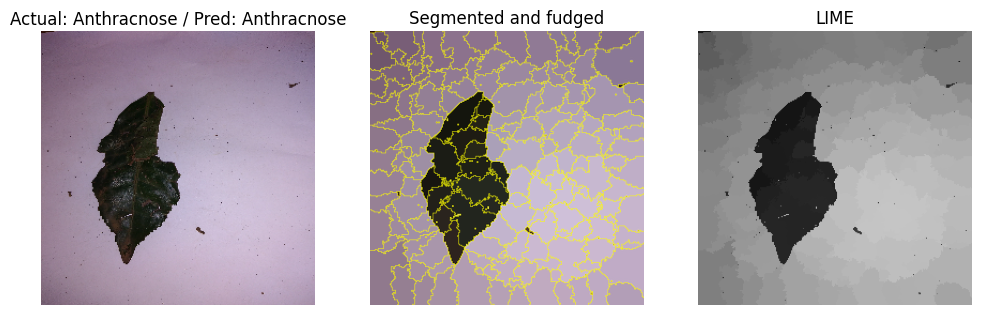

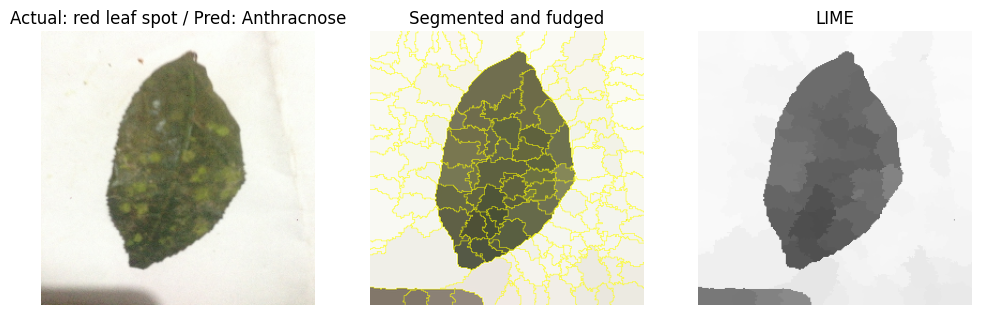

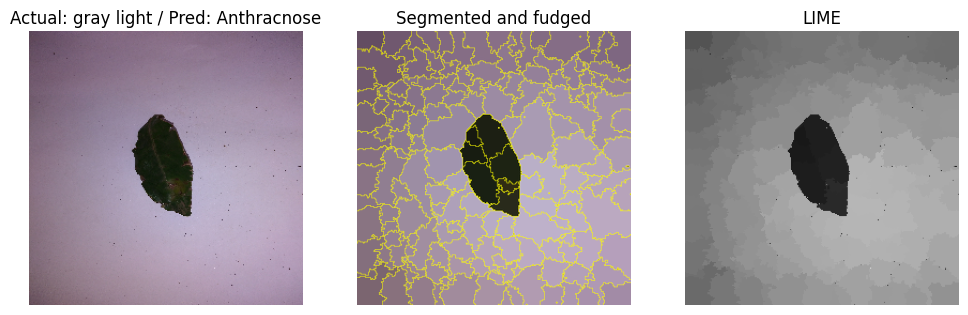

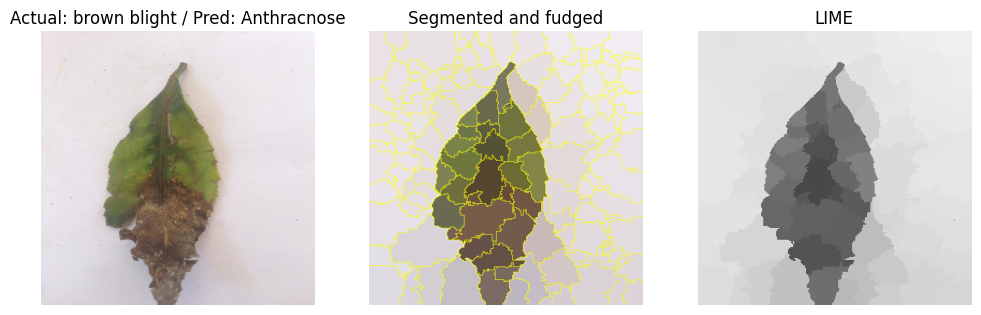

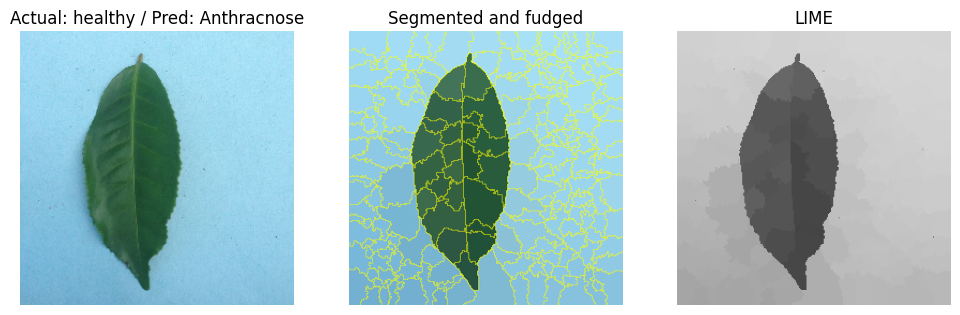

In [ ]:
%%time
# [25, 32, 43, 56, 219]
for each_index in range(0, 20):
    image = image_test[each_index]
    label = label_test_str[each_index]
    glass, fudged, seg = lime_image(image, label, class_dict, model)

    predicted = class_names[model.predict(image[np.newaxis, ...]).argmax()]
    fig_test, ax_test = display_lime(image, fudged, seg, glass, mode="subpixel")
    ax_test[0].set_title(f"Actual: {label} / Pred: {predicted}")